# Homework 7
## Group 21C
- Daniel Noriega
- Fernando Urbano
- Xianbin Xu

In [108]:
# Packages to import
import pandas as pd
import numpy as np
pd.options.display.float_format = "{:,.4f}".format
from typing import Union, List

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

from scipy.stats import norm

import re

def calc_tangency_weights(
        returns: pd.DataFrame,
        cov_mat: str= 1,
        return_graphic: bool = False,
        return_port_ret: bool = False,
        target_ret_rescale_weights: Union[None, float] = None,
        name: str = 'Tangency',
        annual_factor = 12
    ):
    returns = returns.copy()
    
    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    if cov_mat == 1:
        cov_inv = np.linalg.inv((returns.cov() * annual_factor))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1 - cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat * annual_factor))  
        
    ones = np.ones(returns.columns.shape) 
    mu = returns.mean() * annual_factor
    scaling = 1 / (np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling * (cov_inv @ mu)
    tangency_wts = pd.DataFrame(
        index=returns.columns,
        data=tangent_return,
        columns=[f'{name} Weights']
    )
    port_returns = returns @ tangency_wts.rename({f'{name} Weights': f'{name} Portfolio'}, axis=1)

    if return_graphic:
        tangency_wts.plot(kind='bar', title=f'{name} Weights')

    if isinstance(target_ret_rescale_weights, (float, int)):
        scaler = target_ret_rescale_weights / port_returns[f'{name} Portfolio'].mean()
        tangency_wts[[f'{name} Weights']] *= scaler
        port_returns *= scaler
        tangency_wts = tangency_wts.rename(
            {f'{name} Weights': f'{name} Weights Rescaled Target {target_ret_rescale_weights:.2%}'},
            axis=1
        )
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio Rescaled Target {target_ret_rescale_weights:.2%}'},
            axis=1
        )

    if cov_mat != 1:
        port_returns = port_returns.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized {cov_mat:.2f}'))
        tangency_wts = tangency_wts.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized {cov_mat:.2f}'))
        
    if return_port_ret:
        return port_returns
    return tangency_wts



def calc_correlations(
        returns: pd.DataFrame,
        print_highest_lowest: bool = True,
        matrix_size: Union[int, float] = 7,
        return_heatmap: bool = True
    ):
    returns = returns.copy()

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    correlation_matrix = returns.corr()
    if return_heatmap:
        fig, ax = plt.subplots(figsize=(matrix_size * 1.5, matrix_size))
        heatmap = sns.heatmap(
            correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            annot=True,
        )

    if print_highest_lowest:
        highest_lowest_corr = (
            correlation_matrix
            .unstack()
            .sort_values()
            .reset_index()
            .set_axis(['asset_1', 'asset_2', 'corr'], axis=1)
            .loc[lambda df: df.asset_1 != df.asset_2]
        )
        highest_corr = highest_lowest_corr.iloc[lambda df: len(df)-1, :]
        lowest_corr = highest_lowest_corr.iloc[0, :]
        print(f'The highest correlation ({highest_corr["corr"]:.2%}) is between {highest_corr.asset_1} and {highest_corr.asset_2}')
        print(f'The lowest correlation ({lowest_corr["corr"]:.2%}) is between {lowest_corr.asset_1} and {lowest_corr.asset_2}')
    
    if return_heatmap:
        return heatmap
    else:
        return correlation_matrix
    

def calc_summary_statistics(
        returns: Union[pd.DataFrame, List],
        annual_factor: int = None,
        provided_excess_returns: bool = None,
        rf: pd.Series = None,
        var_quantile: Union[float, List] = .05
    ):
    returns = returns.copy()
    if isinstance(rf, (pd.Series, pd.DataFrame)):
        rf = rf.copy()
        
    if isinstance(returns, list):
        returns_list = returns[:]
        returns = pd.DataFrame({})
        for series in returns_list:
            returns = returns.merge(series, right_index=True, left_index=True, how='outer')
    """
    This functions returns the summary statistics for the input total/excess returns passed
    into the function
    """
    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    if annual_factor is None:
        print('Assuming monthly returns with annualization term of 12')
        annual_factor = 12

    if provided_excess_returns is None:
        print(
            'Assuming excess returns were provided to calculate Sharpe.'
            ' If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"'
        )
        provided_excess_returns = True
    elif provided_excess_returns is False:
        if rf is not None:
            if len(rf.index) != len(returns.index):
                raise Exception('"rf" index must be the same lenght as "returns"')
            print('"rf" is used to subtract returns to calculate Sharpe, but nothing else')

    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean()
    summary_statistics['Annualized Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std()
    summary_statistics['Annualized Vol'] = returns.std() * np.sqrt(annual_factor)
    try:
        if not provided_excess_returns:
            if type(rf) == pd.DataFrame:
                rf = rf.iloc[:, 0].to_list()
            elif type(rf) == pd.Series:
                rf = rf.to_list()
            else:
                raise Exception('"rf" must be either a pd.DataFrame or pd.Series')
            excess_returns = returns.apply(lambda x: x - rf)
            summary_statistics['Sharpe'] = excess_returns.mean() / returns.std()
        else:
            summary_statistics['Sharpe'] = returns.mean() / returns.std()
    except Exception as e:
        print(f'Could not calculate Sharpe: {e}')
    summary_statistics['Annualized Sharpe'] = summary_statistics['Sharpe'] * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    var_quantile = [var_quantile] if isinstance(var_quantile, (float, int)) else var_quantile
    for var_q in var_quantile:
        summary_statistics[f'Historical VaR ({var_q:.2%})'] = returns.quantile(var_q, axis = 0)
        summary_statistics[f'Annualized Historical VaR ({var_q:.2%})'] = returns.quantile(var_q, axis = 0) * np.sqrt(annual_factor)
        summary_statistics[f'Historical CVaR ({var_q:.2%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean()
        summary_statistics[f'Annualized Historical CVaR ({var_q:.2%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean() * np.sqrt(annual_factor)
    
    wealth_index = 1000 * (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_statistics['Max Drawdown'] = drawdowns.min()
    summary_statistics['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_statistics['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_statistics['Recovery'] = recovery_date
    try:
        summary_statistics["Duration (days)"] = [
            (i - j).days if i != "-" else "-" for i, j in
            zip(summary_statistics["Recovery"], summary_statistics["Bottom"])
        ]
    except (AttributeError, TypeError) as e:
        print(f'Cannot calculate "Drawdown Duration" calculation because index are not dates: {str(e)}')
    
    return summary_statistics


def calc_regression(
        y: Union[pd.DataFrame, pd.Series],
        X: Union[pd.DataFrame, pd.Series],
        intercept: bool = True,
        annual_factor: Union[None, int] = 12,
        warnings: bool = True,
        return_model: bool = False,
        calc_treynor_info_ratios: bool = True
    ):
    y = y.copy()
    X = X.copy()
    
    if 'date' in X.columns.str.lower():
        X = X.rename({'Date': 'date'}, axis=1)
        X = X.set_index('date')
    X.index.name = 'date'
    
    if warnings:
        print('"calc_regression" assumes excess returns to calculate Information and Treynor Ratios')
    if intercept:
        X = sm.add_constant(X)
    
    y_name = y.name if isinstance(y, pd.Series) else y.columns[0]
    
    try:
        model = sm.OLS(y, X, missing="drop")
    except ValueError:
        y = y.reset_index(drop=True)
        X = X.reset_index(drop=True)
        model = sm.OLS(y, X, missing="drop")
        if warnings:
            print(f'"{y_name}" Required to reset indexes to make regression work. Try passing "y" and "X" as pd.DataFrame')
    results = model.fit()
    summary = dict()

    if return_model:
        return results

    inter = results.params[0] if intercept else None
    betas = results.params[1:] if intercept else results.params

    summary["Alpha"] = inter if inter is not None else '-'
    summary["Annualized Alpha"] = inter * annual_factor if inter is not None else '-'
    summary["R-Squared"] = results.rsquared

    if isinstance(X, pd.Series):
        X = pd.DataFrame(X)

    X_assets = X.columns[1:] if intercept else X.columns
    for i, asset_name in enumerate(X_assets):
        summary[f"{asset_name} Beta"] = betas[i]

    if calc_treynor_info_ratios:
        if len([c for c in X.columns if c != 'const']) == 1:
            summary["Treynor Ratio"] = (y.mean() / betas[0])
            summary["Annualized Treynor Ratio"] = summary["Treynor Ratio"] * annual_factor
        summary["Information Ratio"] = (inter / results.resid.std()) if intercept else "-"
        summary["Annualized Information Ratio"] = summary["Information Ratio"] * np.sqrt(annual_factor) if intercept else "-"
    summary["Tracking Error"] = results.resid.std()
    summary["Annualized Tracking Error"] = results.resid.std() * np.sqrt(annual_factor)
    summary['Fitted Mean'] = results.fittedvalues.mean()
    summary['Annualized Fitted Mean'] = summary['Fitted Mean'] * annual_factor
    y_name = f"{y_name} no Intercept" if not intercept else y_name
    return pd.DataFrame(summary, index=[y_name])


def calc_iterative_regression(
        multiple_y: Union[pd.DataFrame, pd.Series],
        X: Union[pd.DataFrame, pd.Series],
        annual_factor: Union[None, int] = 12,
        intercept: bool = True,
        warnings: bool = True,
        calc_treynor_info_ratios: bool = True
    ):
    multiple_y = multiple_y.copy()
    X = X.copy()

    if 'date' in multiple_y.columns.str.lower():
        multiple_y = multiple_y.rename({'Date': 'date'}, axis=1)
        multiple_y = multiple_y.set_index('date')
    multiple_y.index.name = 'date'

    if 'date' in X.columns.str.lower():
        X = X.rename({'Date': 'date'}, axis=1)
        X = X.set_index('date')
    X.index.name = 'date'

    regressions = pd.DataFrame({})
    for asset in multiple_y.columns:
        y = multiple_y[[asset]]
        new_regression = calc_regression(
            y, X, annual_factor=annual_factor, intercept=intercept, warnings=warnings,
            calc_treynor_info_ratios=calc_treynor_info_ratios
        )
        regressions = pd.concat([regressions, new_regression], axis=0)
    
    return regressions

## 2. Analyzing GMO

##### 2.1. Calculate the mean, volatility, and Sharpe ratio for GMWAX. Do this for three samples:
- from inception through 2011
- 2012-present
- inception - present

Has the mean, vol, and Sharpe changed much since the case?

<font color='blue'>

The change in mean is considerable. After 2011, the average mean return is double of what it was before. On the other hand, vol was higher before 2011, leading to a smaller Sharpe ratio for the first period as well.

</font>

In [109]:
gmo = pd.read_excel('gmo_analysis_data.xlsx', sheet_name='returns (total)', index_col=0)
rf = pd.read_excel('gmo_analysis_data.xlsx', sheet_name='risk-free rate', index_col=0)
gmo.rename(columns=lambda c: c.lower(), inplace=True)
gmwax = (
    gmo[['gmwax']]
    .dropna(axis=0)
    .join(rf.rename(columns=lambda c: c.lower()), how='left')
    .assign(gmwax=lambda df: df.gmwax - df.us3m)
    .drop('us3m', axis=1)
)
spy = (
    gmo[['spy']]
    .dropna(axis=0)
    .join(rf.rename(columns=lambda c: c.lower()), how='left')
    .assign(spy=lambda df: df.spy - df.us3m)
    .drop('us3m', axis=1)
)
signals = pd.read_excel('gmo_analysis_data.xlsx', sheet_name='signals', index_col=0)
signals.rename(columns=lambda c: c.lower(), inplace=True)
gmwax.head()

,gmwax
1996-11-30,0.0409
1996-12-31,-0.0156
1997-01-31,0.0104
1997-02-28,0.0179
1997-03-31,-0.0196


<Axes: title={'center': 'GMO Global Asset Allocation Fund (GMWAX) Excess Returns'}>

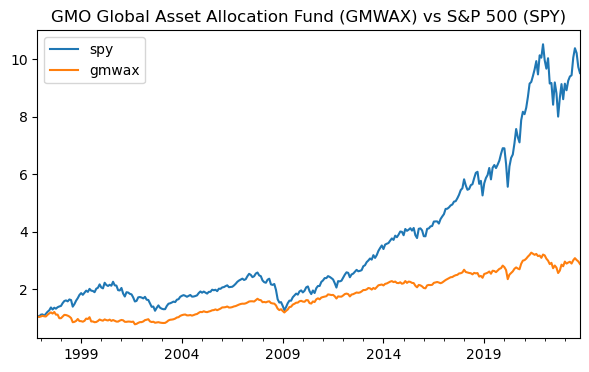

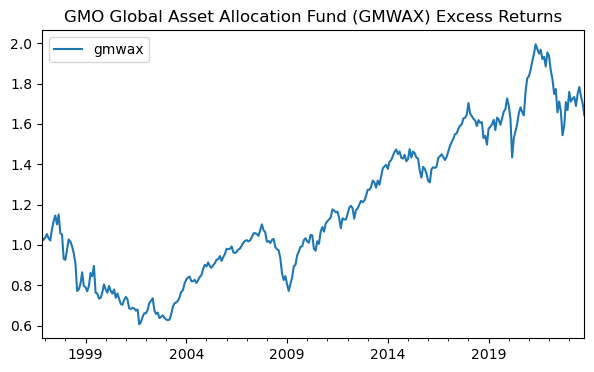

In [110]:
(
    gmo
    .dropna(axis=0)
    .apply(lambda df: df + 1)
    .cumprod()
    .plot(title='GMO Global Asset Allocation Fund (GMWAX) vs S&P 500 (SPY)', figsize=(7, 4))
)
(
    gmwax
    .dropna(axis=0)
    .apply(lambda df: df + 1)
    .cumprod()
    .plot(title='GMO Global Asset Allocation Fund (GMWAX) Excess Returns', figsize=(7, 4))
)

In [111]:
gmwax_stats = calc_summary_statistics([
    gmwax.loc[:'2011-12-31', :].set_axis(['GMO 1996-2011'], axis=1),
    gmwax.loc['2012-01-01':, :].set_axis(['GMO 2012-2023'], axis=1),
    gmwax.set_axis(['GMO 1996-2023'], axis=1)
])
gmwax_stats.loc[:, ['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe']]

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Annualized Mean,Annualized Vol,Annualized Sharpe
GMO 1996-2011,0.0158,0.1250,0.1266
GMO 2012-2023,0.0364,0.0945,0.3856
GMO 1996-2023,0.0249,0.1125,0.2209


<Axes: title={'center': 'GMO Annualized Statistics'}>

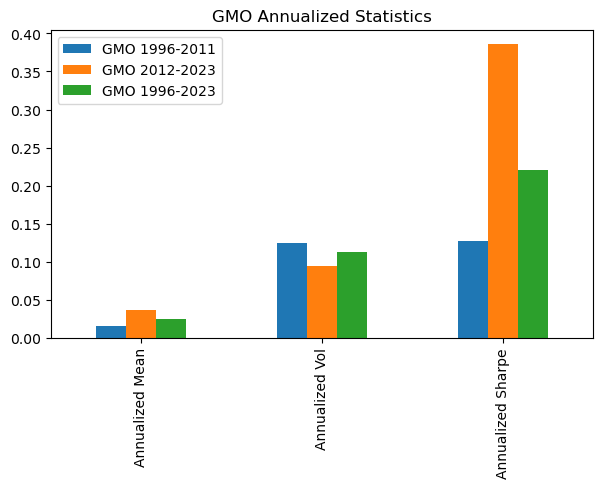

In [112]:
(
    gmwax_stats
    .loc[:, ['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe']]
    .transpose()
    .plot(kind='bar', title='GMO Annualized Statistics', figsize=(7, 4))
)

##### 2.2. GMO believes a risk premium is compensation for a security’s tendency to lose money at “bad times”. For all three samples, analyze extreme scenarios by looking at

- Min return
- 5th percentile (VaR-5th)
- Maximum drawdown

(a) Does GMWAX have high or low tail-risk as seen by these stats?

<font color='blue'>
The tail risk is high: the excess kurtosis is between 2.6-3.2, with an average of 3.

Futhermore, the maxdrawdown is considerably big specially in the timeframe that includes the 2008 crisis.
</font>

(b) Does that vary much across the two subsamples?

<font color='blue'>
The kursosis is higher in the period between 1996 and 2011, but not considerably different from the 2012-2023 period. Historical VaR is 50% bigger for 1996-2011 period, which is partially attribute to the bad historical returns during the 2008 crisis.
</font>



In [113]:
gmwax_risk_stats = (
    gmwax_stats
    .transpose()
    .loc[['Max Drawdown', 'Annualized Historical VaR (5.00%)', 'Min', 'Excess Kurtosis']]
)
gmwax_risk_stats

,GMO 1996-2011,GMO 2012-2023,GMO 1996-2023
Max Drawdown,-0.4729,-0.2260,-0.4729
Annualized Historical VaR (5.00%),-0.2072,-0.1310,-0.1630
Min,-0.1492,-0.1187,-0.1492
Excess Kurtosis,3.0862,2.4882,3.3783


##### 2.3. For all three samples, regress excess returns of GMWAX on excess returns of SPY.

(a) Report the estimated alpha, beta, and r-squared.

(b) Is GMWAX a low-beta strategy? Has that changed since the case?

<font color='blue'>
It is a moderate beta strategy. It always has a beta between 0.53-0.57.

It hasn't changed overtime a lot.
</font>

(c) Does GMWAX provide alpha? Has that changed across the subsamples?

<font color='blue'>
It provides a negative alpha every time, with a increase in value after 2011.
</font>

In [114]:
gmwax_first = gmwax.loc[:'2011-12-31', :].set_axis(['GMO 1996-2011'], axis=1).join(spy, how='left')
gmwax_last = gmwax.loc['2012-01-01':, :].set_axis(['GMO 2012-2023'], axis=1).join(spy, how='left')
gmwax_full = gmwax.set_axis(['GMO 1996-2023'], axis=1).join(spy, how='left')
gmwax_reg_stats = (
    pd.concat([
        calc_regression(gmwax_first[['GMO 1996-2011']], gmwax_first[['spy']], warnings=False),
        calc_regression(gmwax_last[['GMO 2012-2023']], gmwax_last[['spy']], warnings=False),
        calc_regression(gmwax_full[['GMO 1996-2023']], gmwax_full[['spy']], warnings=False),
    ])
    .rename({'spy Beta': 'SPY Beta'}, axis=1)
)
gmwax_reg_stats.loc[:, ['Annualized Alpha', 'R-Squared', 'SPY Beta']]

,Annualized Alpha,R-Squared,SPY Beta
GMO 1996-2011,-0.0058,0.5071,0.5396
GMO 2012-2023,-0.0327,0.7544,0.5738
GMO 1996-2023,-0.0166,0.5821,0.5506


## 3. Forecast Regressions

##### 3.1. Consider the lagged regression.
Estimate (1) and report the R2, as well as the OLS estimates for α and β. Do this for...
- X as a single regressor, the dividend-price ratio.
- X as a single regressor, the earnings-price ratio.
- X as three regressors, the dividend-price ratio, the earnings-price ratio, and the 10-year
yield.

In [115]:
forecast_reg = (
    gmo[['spy']]
    .join(signals, how='outer')
    .assign(**{v: (lambda df, col=v: df[col].shift()) for v in signals.columns})
    .rename(columns=lambda c: c + "_lag" if c != "spy" else c)
    .dropna()
)
forecast_reg.head()

,spy,dp_lag,ep_lag,us10y_lag
1993-03-31,0.0224,2.8200,4.4400,6.0300
1993-04-30,-0.0256,2.7700,4.4100,6.0300
1993-05-31,0.0270,2.8200,4.4400,6.0500
1993-06-30,0.0037,2.8100,4.3800,6.1600
1993-07-31,-0.0049,2.7900,4.3100,5.8000


In [116]:
(
    pd.concat([
        calc_regression(forecast_reg['spy'], forecast_reg[['dp_lag']], warnings=False).filter(regex='(?i)(alpha|beta|square)'),
        calc_regression(forecast_reg['spy'], forecast_reg[['ep_lag']], warnings=False).filter(regex='(?i)(alpha|beta|square)'),
        calc_regression(forecast_reg['spy'], forecast_reg.drop('spy', axis=1), warnings=False).filter(regex='(?i)(alpha|beta|square)')
    ], axis=0)
    .set_axis(['DP', 'EP', 'Full'], axis=0)
)

,Alpha,Annualized Alpha,R-Squared,dp_lag Beta,ep_lag Beta,us10y_lag Beta
DP,-0.0095,-0.1138,0.0094,0.0095,NaN,NaN
EP,-0.0062,-0.0739,0.0087,NaN,0.0033,NaN
Full,-0.0151,-0.1808,0.0164,0.0080,0.0027,-0.0010


##### 3.2. For each of the three regressions, let’s try to utilize the resulting forecast in a trading strategy
Build the forecasted SPY returns. Note that this denotes the forecast made using Xt to forecast the (t + 1) return.

Set the scale of the investment in SPY equal to 100 times the forecasted value.

Calculate the return on this strategy.

You should now have the trading strategy returns, r^x for each of the forecasts. For each strategy, estimate:

- mean, volatility, Sharpe,
- max-drawdown
- market alpha
- market beta
- market Information ratio

In [117]:
spy_dp_model = calc_regression(forecast_reg['spy'], forecast_reg[['dp_lag']], return_model=True, warnings=False)
spy_dp_weights = spy_dp_model.fittedvalues * 100
spy_dp_ret = (
    spy
    .join(spy_dp_weights.to_frame('weights'), how='inner')
    .assign(spy_dp=lambda df: df.spy * df.weights)
    .filter(['spy_dp'])
)
spy_ep_model = calc_regression(forecast_reg['spy'], forecast_reg[['ep_lag']], return_model=True, warnings=False)
spy_ep_weights = spy_ep_model.fittedvalues * 100
spy_ep_ret = (
    spy
    .join(spy_ep_weights.to_frame('weights'), how='inner')
    .assign(spy_ep=lambda df: df.spy * df.weights)
    .filter(['spy_ep'])
)
spy_full_model = calc_regression(forecast_reg['spy'], forecast_reg.drop('spy', axis=1), return_model=True, warnings=False)
spy_full_weights = spy_full_model.fittedvalues * 100
spy_full_ret = (
    spy
    .join(spy_full_weights.to_frame('weights'), how='inner')
    .assign(spy_full=lambda df: df.spy * df.weights)
    .filter(['spy_full'])
)
(
    calc_summary_statistics([spy_dp_ret, spy_ep_ret, spy_full_ret])
    .loc[:, ['Mean', 'Sharpe', 'Vol', 'Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Max Drawdown']]
    .transpose()
)


Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,spy_dp,spy_ep,spy_full
Mean,0.0075,0.0072,0.0090
Sharpe,0.1762,0.1957,0.2157
Vol,0.0428,0.0370,0.0418
Annualized Mean,0.0906,0.0869,0.1083
Annualized Vol,0.1484,0.1282,0.1450
Annualized Sharpe,0.6104,0.6779,0.7472
Max Drawdown,-0.6635,-0.3966,-0.5329


In [118]:
in_sample_ret = pd.concat([spy_dp_ret, spy_ep_ret, spy_full_ret], axis=1).join(spy, how='inner')
in_sample_mkt_reg = (
    calc_iterative_regression(in_sample_ret.drop('spy', axis=1), in_sample_ret[['spy']])
    .filter(regex='(?i)(alpha|beta|square|information)')
)
in_sample_mkt_reg

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios
"calc_regression" assumes excess returns to calculate Information and Treynor Ratios
"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,Alpha,Annualized Alpha,R-Squared,spy Beta,Information Ratio,Annualized Information Ratio
spy_dp,0.0019,0.0223,0.7488,0.8599,0.0865,0.2996
spy_ep,0.0024,0.0288,0.7267,0.7319,0.1239,0.4293
spy_full,0.0039,0.0468,0.6367,0.7748,0.1546,0.5355


##### 3.3. GMO believes a risk premium is compensation for a security’s tendency to lose money at “bad times”. Let’s consider risk characteristics.
(a) For both strategies, the market, and GMO, calculate the monthly VaR for π = .05. Just
use the quantile of the historic data for this VaR calculation.

In [119]:
calc_summary_statistics([spy_dp_ret, spy_ep_ret, spy_full_ret, gmo['spy'], gmo['gmwax']]).filter(regex='VaR').transpose()

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,spy_dp,spy_ep,spy_full,spy,gmwax
Historical VaR (5.00%),-0.0535,-0.0561,-0.0654,-0.0721,-0.0468
Annualized Historical VaR (5.00%),-0.1853,-0.1944,-0.2265,-0.2497,-0.1622
Historical CVaR (5.00%),-0.0962,-0.0764,-0.0932,-0.0956,-0.0811
Annualized Historical CVaR (5.00%),-0.3334,-0.2648,-0.3229,-0.3312,-0.2811


(b) The GMO case mentions that stocks under-performed short-term bonds from 2000-2011.
Does the dynamic portfolio above under-perform the risk-free rate over this time?

<Axes: title={'center': 'In-Sample Excess Returns'}>

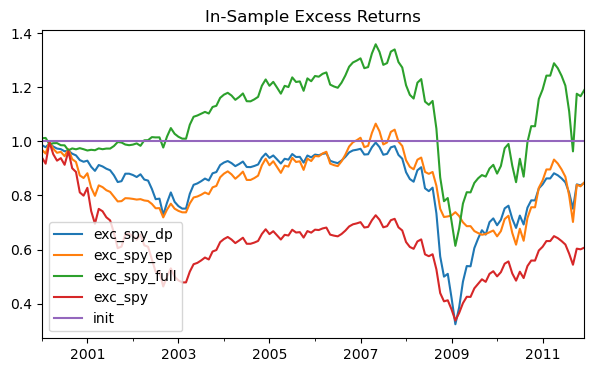

In [120]:
in_sample_exc_ret = (
    in_sample_ret.join(rf.rename(columns=lambda c: c.lower()), how='inner')
    .loc['2000':'2011']
    .assign(**{f'exc_{v}': (lambda df, col=v: df[col] - df['us3m']) for v in ['spy_dp', 'spy_ep', 'spy_full', 'spy']})
    .filter(regex='(?i)(exc)')
)
(
    in_sample_exc_ret
    .apply(lambda df: df + 1)
    .cumprod()
    .assign(init=1)
    .plot(title='In-Sample Excess Returns', figsize=(7, 4))
)

(c) Based on the regression estimates, in how many periods do we estimate a negative risk
premium?

<font color='blue'>
Considering risk-premium as returns below the risk-free rate, we can check that all the models have the same amount of returns above the risk-free rate, which accounts for ~60%. The SPY has one less monthly return above the risk-free rate than the models.
</font>

In [121]:
(
    in_sample_ret.join(rf.rename(columns=lambda c: c.lower()), how='inner')
    .assign(**{f'exc_{v}': (lambda df, col=v: df[col] - df['us3m']) for v in ['spy_dp', 'spy_ep', 'spy_full', 'spy']})
    .filter(regex='(?i)(exc)')
    .apply(lambda df: df > 0)
    .astype(int)
    .agg(['mean', 'sum'])
)

,exc_spy_dp,exc_spy_ep,exc_spy_full,exc_spy
mean,0.5978,0.5978,0.5978,0.6087
sum,220.0000,220.0000,220.0000,224.0000


(d) Do you believe the dynamic strategy takes on extra risk??

<font color='blue'>
Yes! As we can see, the negative alpha combined with R-Squared between 60-70% shows that there are other systematic risks that are taken by the strategies. The affirmation is particularly true for the model that uses 3 regressors.
</font>

## 4. Out-of-Sample Forecasting

<font color='blue'>
We construct three strategies OOS:

- Using DP + EP
- Using DP
- Using EP

</font>

##### OOS DP & EP

OOS R-Squared: -3.17%


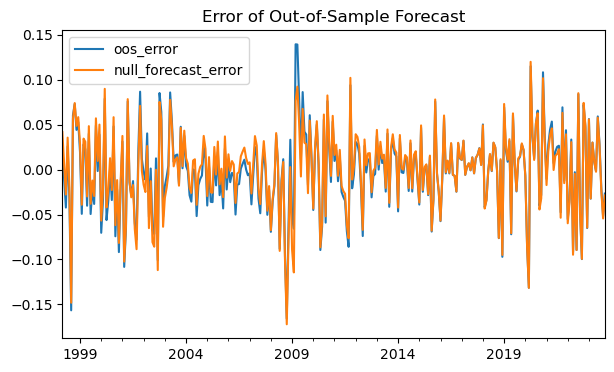

In [122]:
limit_dates = in_sample_ret.index[60:]
oos_dp_ep_sample_ret = pd.DataFrame({})
for date in limit_dates:
    training_reg = forecast_reg.loc[lambda df: df.index < date]
    spy_dp_model = calc_regression(training_reg['spy'], training_reg.drop(['spy', 'us10y_lag'], axis=1), return_model=True, warnings=False)
    pred_feature = forecast_reg.loc[date:date].drop(['spy', 'us10y_lag'], axis=1).transpose().iloc[:, 0].to_numpy().tolist()
    pred_target = spy_dp_model.predict([1] + pred_feature)
    oos_dp_ep_sample_ret.loc[date, 'spy_oos_dp_ep'] = pred_target[0]
oos_dp_ep_sample_ret.head(5)
oos_dp_ep_error_analysis = (
    oos_dp_ep_sample_ret
    .join(forecast_reg, how='inner')
    .filter(regex='(?i)(spy)')
    .assign(oos_error=lambda df: df.spy - df.spy_oos_dp_ep)
    .assign(null_forecast_error=lambda df: df.spy - df.spy.mean())
)
oos_dp_ep_error_analysis.filter(regex='error').plot(title='Error of Out-of-Sample Forecast', figsize=(7, 4));
oos_dp_ep_rsquared = 1 - ((oos_dp_ep_error_analysis.oos_error ** 2).sum() / (oos_dp_ep_error_analysis.null_forecast_error ** 2).sum())
print(f'OOS R-Squared: {oos_dp_ep_rsquared:.2%}')

##### OOS DP

OOS R-Squared: -1.74%


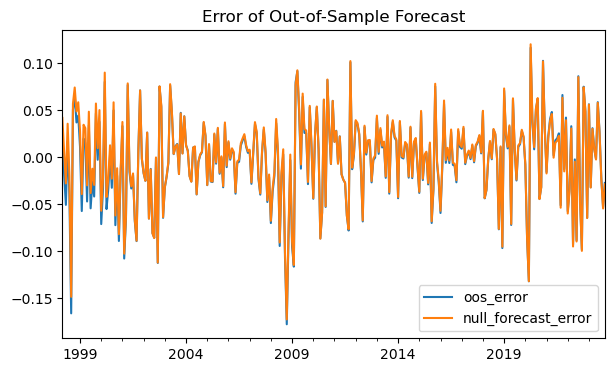

In [123]:
limit_dates = in_sample_ret.index[60:]
oos_dp_sample_ret = pd.DataFrame({})
for date in limit_dates:
    training_reg = forecast_reg.loc[lambda df: df.index < date]
    spy_dp_model = calc_regression(training_reg['spy'], training_reg.drop(['spy', 'us10y_lag', 'ep_lag'], axis=1), return_model=True, warnings=False)
    pred_feature = forecast_reg.loc[date:date].drop(['spy', 'us10y_lag', 'ep_lag'], axis=1).transpose().iloc[:, 0].to_numpy().tolist()
    pred_target = spy_dp_model.predict([1] + pred_feature)
    oos_dp_sample_ret.loc[date, 'spy_oos_dp'] = pred_target[0]
oos_dp_sample_ret.head(5)
oos_dp_error_analysis = (
    oos_dp_sample_ret
    .join(forecast_reg, how='inner')
    .filter(regex='(?i)(spy)')
    .assign(oos_error=lambda df: df.spy - df.spy_oos_dp)
    .assign(null_forecast_error=lambda df: df.spy - df.spy.mean())
)
oos_dp_error_analysis.filter(regex='error').plot(title='Error of Out-of-Sample Forecast', figsize=(7, 4))
oos_dp_rsquared = 1 - ((oos_dp_error_analysis.oos_error ** 2).sum() / (oos_dp_error_analysis.null_forecast_error ** 2).sum())
print(f'OOS R-Squared: {oos_dp_rsquared:.2%}')

##### OOS EP

OOS R-Squared: -1.90%


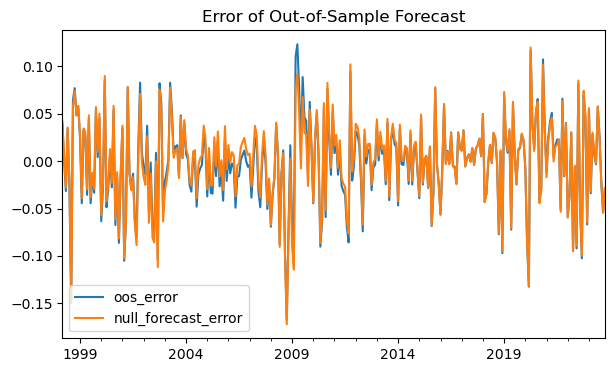

In [124]:
limit_dates = in_sample_ret.index[60:]
oos_ep_sample_ret = pd.DataFrame({})
for date in limit_dates:
    training_reg = forecast_reg.loc[lambda df: df.index < date]
    spy_ep_model = calc_regression(training_reg['spy'], training_reg.drop(['spy', 'us10y_lag', 'dp_lag'], axis=1), return_model=True, warnings=False)
    pred_feature = forecast_reg.loc[date:date].drop(['spy', 'us10y_lag', 'dp_lag'], axis=1).transpose().iloc[:, 0].to_numpy().tolist()
    pred_target = spy_ep_model.predict([1] + pred_feature)
    oos_ep_sample_ret.loc[date, 'spy_oos_ep'] = pred_target[0]
oos_ep_sample_ret.head(5)
oos_ep_error_analysis = (
    oos_ep_sample_ret
    .join(forecast_reg, how='inner')
    .filter(regex='(?i)(spy)')
    .assign(oos_error=lambda df: df.spy - df.spy_oos_ep)
    .assign(null_forecast_error=lambda df: df.spy - df.spy.mean())
)
oos_ep_error_analysis.filter(regex='error').plot(title='Error of Out-of-Sample Forecast', figsize=(7, 4))
oos_ep_rsquared = 1 - ((oos_ep_error_analysis.oos_error ** 2).sum() / (oos_ep_error_analysis.null_forecast_error ** 2).sum())
print(f'OOS R-Squared: {oos_ep_rsquared:.2%}')

##### 4.1. Report the out-of-sample R2
<font color='blue'>

The R-Squared is negative for all three models made. It is particularly negative for the model using DP + EP.

</font>

In [129]:
print(f'OOS EP R-Squared: {oos_ep_rsquared:.2%}')
print(f'OOS DP R-Squared: {oos_dp_rsquared:.2%}')
print(f'OOS DP + EP R-Squared: {oos_dp_ep_rsquared:.2%}')

OOS EP R-Squared: -1.90%
OOS DP R-Squared: -1.74%
OOS DP + EP R-Squared: -3.17%


##### 4.2. Redo 3.2 comparing the models

How much better/worse is the OOS strategy compared to the in-sample version of 3.2?

<font color='blue'>

All the OOS models perform worst than the In-Sample models. This happens in Sharpe (lower) and also in Skewness + Kurtosis (higher negative skewness and bigger excess kurtosis). The bigger excess Kurtosis shows us that the models out-of-sample have a higher tail risk.

We also see that among the in-sample and the OOS, the models with more regressors have a better Sharpe ratio performance.

</font>

##### 4.3. Re-do problem 3.3 using this OOS forecast.

(a) For both strategies, the market, and GMO, calculate the monthly VaR for π = .05. Just
use the quantile of the historic data for this VaR calculation.

<font color='blue'>

We see that the annualized historical VaR for the OOS strategies is around 50% worst and the annualized historical CVaR 100% worst than the in-sample.

</font>

In [125]:
spy_oos_dp_ep_ret = (
    oos_dp_ep_error_analysis
    .filter(regex='spy_oos')
    .join(spy, how='inner')
    .assign(spy_oos_dp_ep_ret=lambda df: df.spy_oos_dp_ep * 100 * df.spy)
    .filter(regex='_ret')
)
spy_oos_dp_ret = (
    oos_dp_error_analysis
    .filter(regex='spy_oos')
    .join(spy, how='inner')
    .assign(spy_oos_dp_ret=lambda df: df.spy_oos_dp * 100 * df.spy)
    .filter(regex='_ret')
)
spy_oos_ep_ret = (
    oos_ep_error_analysis
    .filter(regex='spy_oos')
    .join(spy, how='inner')
    .assign(spy_oos_ep_ret=lambda df: df.spy_oos_ep * 100 * df.spy)
    .filter(regex='_ret')
)
calc_summary_statistics([spy_dp_ret, spy_ep_ret, spy_full_ret, spy_oos_dp_ep_ret, spy_oos_dp_ret, spy_oos_ep_ret]).transpose()

Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,spy_dp,spy_ep,spy_full,spy_oos_dp_ep_ret,spy_oos_dp_ret,spy_oos_ep_ret
Mean,0.0075,0.0072,0.0090,0.0057,0.0043,0.0050
Annualized Mean,0.0906,0.0869,0.1083,0.0685,0.0511,0.0599
Vol,0.0428,0.0370,0.0418,0.0651,0.0495,0.0472
Annualized Vol,0.1484,0.1282,0.1450,0.2255,0.1715,0.1636
Sharpe,0.1762,0.1957,0.2157,0.0877,0.0860,0.1056
Annualized Sharpe,0.6104,0.6779,0.7472,0.3039,0.2978,0.3659
Min,-0.2299,-0.1210,-0.1714,-0.4668,-0.3573,-0.2382
Max,0.2458,0.1958,0.2211,0.4488,0.1547,0.2247
Skewness,-0.3759,0.1498,0.1402,-0.9284,-1.4409,-0.5056
Excess Kurtosis,8.4362,2.6215,4.6584,20.3440,9.9881,5.2017


<Axes: title={'center': 'In-Sample and Out-of-Sample Returns'}>

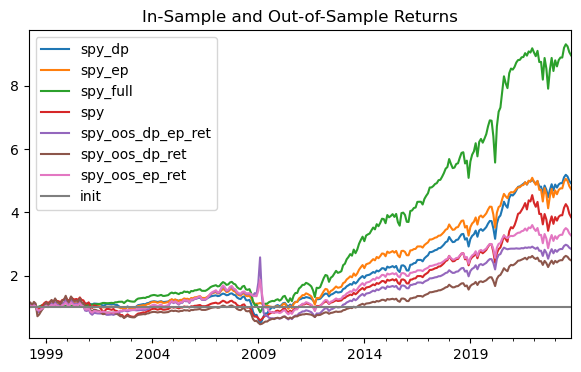

In [126]:
(
    in_sample_ret
    .join(spy_oos_dp_ep_ret, how='inner')
    .join(spy_oos_dp_ret, how='inner')
    .join(spy_oos_ep_ret, how='inner')
    .apply(lambda df: df + 1)
    .cumprod()
    .assign(init=1)
    .plot(title='In-Sample and Out-of-Sample Returns', figsize=(7, 4))
)

In [127]:
oos_ret = pd.concat([spy_oos_dp_ep_ret, spy_oos_dp_ret, spy_oos_ep_ret], axis=1).join(spy, how='inner')
oos_mkt_reg = (
    calc_iterative_regression(oos_ret.drop('spy', axis=1), oos_ret[['spy']], warnings=False)
    .filter(regex='(?i)(alpha|beta|square|information)')
)
pd.concat([in_sample_mkt_reg, oos_mkt_reg], axis=0)

,Alpha,Annualized Alpha,R-Squared,spy Beta,Information Ratio,Annualized Information Ratio
spy_dp,0.0019,0.0223,0.7488,0.8599,0.0865,0.2996
spy_ep,0.0024,0.0288,0.7267,0.7319,0.1239,0.4293
spy_full,0.0039,0.0468,0.6367,0.7748,0.1546,0.5355
spy_oos_dp_ep_ret,0.0032,0.0384,0.1032,0.4647,0.0518,0.1796
spy_oos_dp_ret,-0.0011,-0.0132,0.8086,0.9891,-0.0506,-0.1754
spy_oos_ep_ret,0.0020,0.0241,0.2755,0.5508,0.0500,0.1731


(b) The GMO case mentions that stocks under-performed short-term bonds from 2000-2011.
Does the dynamic portfolio above under-perform the risk-free rate over this time?

<font color='blue'>

All the strategies OOS underperform the risk-free rate between 2000 and 2011.

</font>

<Axes: title={'center': 'Out-of-Sample Excess Returns'}>

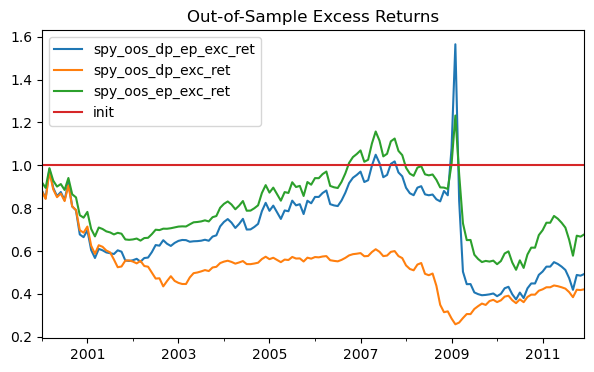

In [139]:
(
    pd.concat([spy_oos_dp_ep_ret, spy_oos_dp_ret, spy_oos_ep_ret], axis=1)
    .join(rf.rename(columns=lambda c: c.lower()), how='inner')
    .assign(**{v: lambda df, col=v: df[col] - df['us3m'] for v in ['spy_oos_dp_ep_ret', 'spy_oos_dp_ret', 'spy_oos_ep_ret']})
    .filter(regex='(?i)(spy)')
    .rename(columns=lambda c: c.replace('_ret', '_exc_ret'))
    .apply(lambda df: df + 1)
    .loc['2000':'2011']
    .cumprod()
    .assign(init=1)
    .plot(title='Out-of-Sample Excess Returns', figsize=(7, 4))
)

(c) Based on the regression estimates, in how many periods do we estimate a negative risk
premium?

<font color='blue'>

Looking in a monthly analysis, the result of months with positive risk premium is 58.5% for the strategies with DP + EP and DP alone. The result is a little bit better for the strategy with EP, with 59.4% of months with positive excess returns.

The result is a little bit worst than the in-sample analysis. This agrees with the idea that, while the mean between the models in-sample vs. OOS differ in a little bit, the tails of returns are much worst in the OOS.

</font>

In [140]:
(
    pd.concat([spy_oos_dp_ep_ret, spy_oos_dp_ret, spy_oos_ep_ret], axis=1)
    .join(rf.rename(columns=lambda c: c.lower()), how='inner')
    .assign(**{v: lambda df, col=v: df[col] - df['us3m'] for v in ['spy_oos_dp_ep_ret', 'spy_oos_dp_ret', 'spy_oos_ep_ret']})
    .filter(regex='(?i)(spy)')
    .rename(columns=lambda c: c.replace('_ret', '_exc_ret'))
    .apply(lambda df: df > 0)
    .astype(int)
    .agg(['mean', 'sum'])
)

,spy_oos_dp_ep_exc_ret,spy_oos_dp_exc_ret,spy_oos_ep_exc_ret
mean,0.5844,0.5877,0.5942
sum,180.0000,181.0000,183.0000


(d) Do you believe the dynamic strategy takes on extra risk??

<font color='blue'>

Yes! Once again, we believe that the dynamic strategies take extra risk, since it has excess return that is not fully explainable by the market risk.

</font>